# What are the effects of aligning and PBC correction on an `*.xtc` file?

Here is a movie of the input file `./first_1000.xtc`, shown with the periodic box.  I've colored the ligand yellow, and the pocket atoms red-to-blue so we can easily discern each atom.

<img src='before.gif'>

Let's load this trajectory into memory and inspect its *xyz* coordinates

In [31]:
import mdtraj as md
before = md.load_xtc('./first_1000.xtc', top='./new_test.pdb')

/Users/vv/anaconda/lib/python2.7/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


This error is interesting, because it might suggest that mdtraj does not like my idea of having coordinates that go from (about) -1.5 to 1.5 in each direction (as specified by the template PDB)...

Instead, lets try to load this in using the `protein.gro` template:

In [32]:
% ls

#protein.pdb.1#      first_1000.xtc       xy.png
README.md            new_test.pdb         xz.png
align_and_pbc.ipynb  protein.gro          yz.png
before.gif           protein.pdb


In [33]:
!gmx editconf -f protein.gro -o protein.pdb

                 :-) GROMACS - gmx editconf, VERSION 5.1.2 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
 Dimitrios Karkoulis    Peter Kasson        Jiri Kraus      Carsten Kutzner  
    Per Larsson      Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff 
   Erik Marklund      Teemu Murtola       Szilard Pall       Sander Pronk   
   Roland Schulz     Alexey Shvetsov     Michael Shirts     Alfons Sijbers  
   Peter Tieleman    Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala Universit

In [34]:
!cat protein.pdb

TITLE     Pocket in Water in water
REMARK    THIS IS A SIMULATION BOX
CRYST1   30.086   30.086   30.086  90.00  90.00  90.00 P 1           1
MODEL        1
ATOM      1  C1  DUM     1      15.290  27.760  20.990  1.00  0.00            
ATOM      2  C2  DUM     1      18.720  26.240  22.530  1.00  0.00            
ATOM      3  C3  DUM     1      13.050  29.320  27.020  1.00  0.00            
ATOM      4  C4  DUM     1      16.640  28.100  28.320  1.00  0.00            
ATOM      5  C5  DUM     1      12.390  27.160  23.700  1.00  0.00            
ATOM      6  C6  DUM     1      14.120   0.710  23.420  1.00  0.00            
ATOM      7  C7  DUM     1      17.890  24.890  26.250  1.00  0.00            
ATOM      8  C8  DUM     1      19.710  28.440  25.740  1.00  0.00            
ATOM      9  C9  DUM     1      15.220  24.440  23.260  1.00  0.00            
ATOM     10  C10 DUM     1      18.020   0.150  22.560  1.00  0.00            
ATOM     11  C11 DUM     1      14.000  25.450  26.960

As we can see, GROMACS likes to make all the coordinates positiive with the origin (0,0,0) in the corner.

Now let's use `protein.pdb` as our template, and inspect the coordinates:

In [35]:
before = md.load_xtc('./first_1000.xtc', top='./protein.pdb')
print '(nframes, natoms, dof) =', before.xyz.shape

# Print the 500th frame
print 'before.xyz[500,:,:]', before.xyz[500,:,:]

(nframes, natoms, dof) = (1000, 12, 3)
before.xyz[500,:,:] [[ 1.9000001   2.4000001   2.60000014]
 [ 1.60000002  2.5         2.5       ]
 [ 2.10000014  3.00000024  2.60000014]
 [ 1.80000007  0.1         2.4000001 ]
 [ 2.20000005  2.60000014  2.5       ]
 [ 2.10000014  2.70000005  2.80000019]
 [ 1.60000002  2.80000019  2.20000005]
 [ 1.50000012  2.9000001   2.60000014]
 [ 1.9000001   2.5         2.20000005]
 [ 1.70000005  2.60000014  2.80000019]
 [ 2.          2.9000001   2.20000005]
 [ 1.20000005  2.30000019  2.60000014]]


## Uh-oh!   This is very disturbing -- all the coordinates are rounded off to the nearest Angstrom?

Let's make a plot of just the *x* vs *y* coordinates of the first atom, and see if there are roundoff errors....

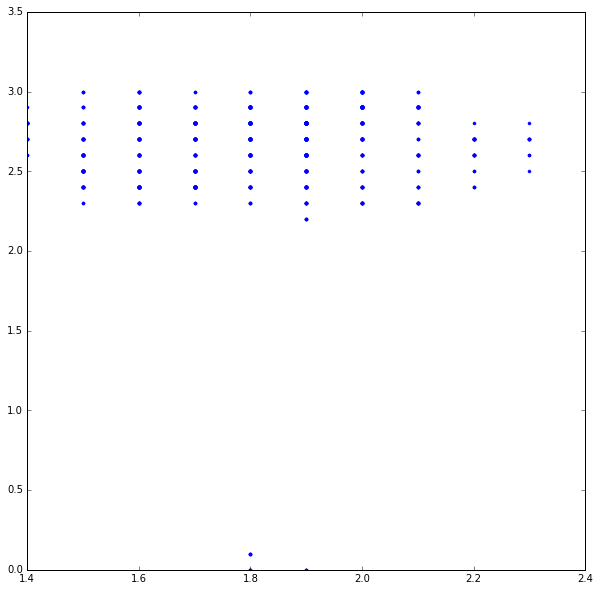

In [36]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure( figsize=(10,10))
plt.plot(before.xyz[:,0,0],before.xyz[:,0,1],'.')

## YUP. :(  Looks like there is a round-off discretization error!!!!

This explains why Yunhui observed some of the coordinates to have *exactly* the same values.  They are essentially discretized in increments of 0.1 nm.

### Some reasons for this *might* be:

* limited precision in the original trajectory, i.e. an `*.mdp` setting?
* loss of precision when transforming from VMD, etc?  Yunhui, how did you make the `./first_1000.xtc` file? 

We can verify that this problem is *not* `mdtraj`, by using `gmxdump` to print the coordinates saved in `./first_1000.xtc`:

In [37]:
!gmx dump -f ./first_1000.xtc

                   :-) GROMACS - gmx dump, VERSION 5.1.2 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
 Dimitrios Karkoulis    Peter Kasson        Jiri Kraus      Carsten Kutzner  
    Per Larsson      Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff 
   Erik Marklund      Teemu Murtola       Szilard Pall       Sander Pronk   
   Roland Schulz     Alexey Shvetsov     Michael Shirts     Alfons Sijbers  
   Peter Tieleman    Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University,